# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera Calibration
### 1.1 Define camera_calibration function
The camera_calibration function calculates mtx and dist matrices from the calibration images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def camera_calibration(file_names, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(file_names)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            #cv2.drawChessboardCorners(img, (nx,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)
# cv2.destroyAllWindows()
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    return mtx, dist

### 1.2  Get mtx and dist matrices and save them for later use

In [2]:
import pickle
%matplotlib inline
nx = 9
ny = 6
# Calculate mtx and dist matrices from camera calibration
mtx, dist = camera_calibration('camera_cal/calibration*.jpg', nx, ny)
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "P2_dist_pickle.p", "wb" ) )

### 1.3 Test undistortion on the calibration images

Text(0.5, 1.0, 'Undistorted Image')

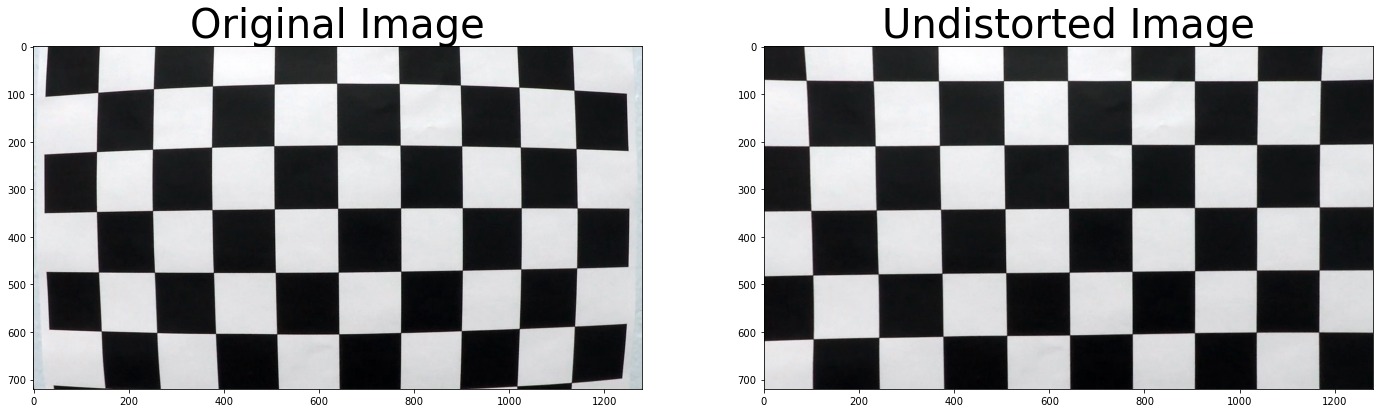

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg', cv2.COLOR_BGR2RGB)

# Read in the saved mtx and dist
dist_pickle = pickle.load( open( "P2_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Undistort the image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=40)

## 2. Pipeline for images
### 2.1 Undistort the image

In [4]:
#Pipeline (test images)
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


### 2.2 Use color transforms, gradients or other methods to create a thresholded binary image

In [5]:
# threshold_binary function to apply color and gradient thresholding.
def threshold_binary(img, sobel_kernel=3, s_thresh=(170, 255), gd_thresh=(20, 100)):
    img = np.copy(img)
    
    # Apply threshold on S channel of HLS color map
    # 1) Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # 2) Threshold color channel
    s_mask = (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])

    # Apply Sobel x and y, then compute the direction of the gradient and apply a threshold.
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gd_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    gd_mask = (gd_dir >= gd_thresh[0]) & (gd_dir <= gd_thresh[1])


    # Combine the thresholding methods
    mask_combined = (s_mask == 1) & (gd_mask == 1)
    
    # Generate binary image
    binary_img = np.zeros_like(sobelx)    
    binary_img[mask_combined] = 255
    
    return binary_img
    

### 2.3 Perform perspective transform

In [6]:
# perspective_transform function transforms the image to a 'bird-eye-view' image
def perspective_transform(img, mtx, dist):

#     # convert to grayscale
#     gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # define 4 source points and 4 destination points
    img_size = (img.shape[1], img.shape[0])
    mid_width = 0.08 # percent of middle trapizoid width
    bot_width = 0.76 # percent of bottom trapizoid width
    height_pct = 0.62 # percent of trapizoid height
    bottom_trim = 0.93 # percent from top to bottom to avoid car hood
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct], \
                      [img.shape[1]*(0.5+mid_width/2), img.shape[0]*height_pct], \
                      [img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim], \
                      [img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img.shape[0] * 0.35
    dst = np.float32([[offset, 0], \
                      [img_size[0]-offset, 0], \
                      [img_size[0]-offset, img_size[1]], \
                      [offset, img_size[1]]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

### 2.4 Identify lane-line pixels and fit their positions with a polynomial

In [7]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=30):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    #nwindows = 9
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint



    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


# def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50):
#     # Find our lane pixels first
#     leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50)

#     ### Fit a second order polynomial to each using `np.polyfit` ###
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
    

#     return left_fit, right_fit, out_img


### 2.5 Calculate the radius of curvature of the lane and the position of the vehicle with respect to center

In [8]:
def measure_curvature(left_fit, right_fit, yvals):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Implement the calculation of R_curve (radius of curvature)
    ## Implement the calculation of the left line here
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5/(2*np.abs(left_fit[0]))  
    ## Implement the calculation of the right line here
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5/(2*np.abs(right_fit[0]))   
    
    return left_curverad, right_curverad

### 2.6 The pipeline and examples

In [9]:
## Step 0: Read in an image
img = cv2.imread('test_images\\test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

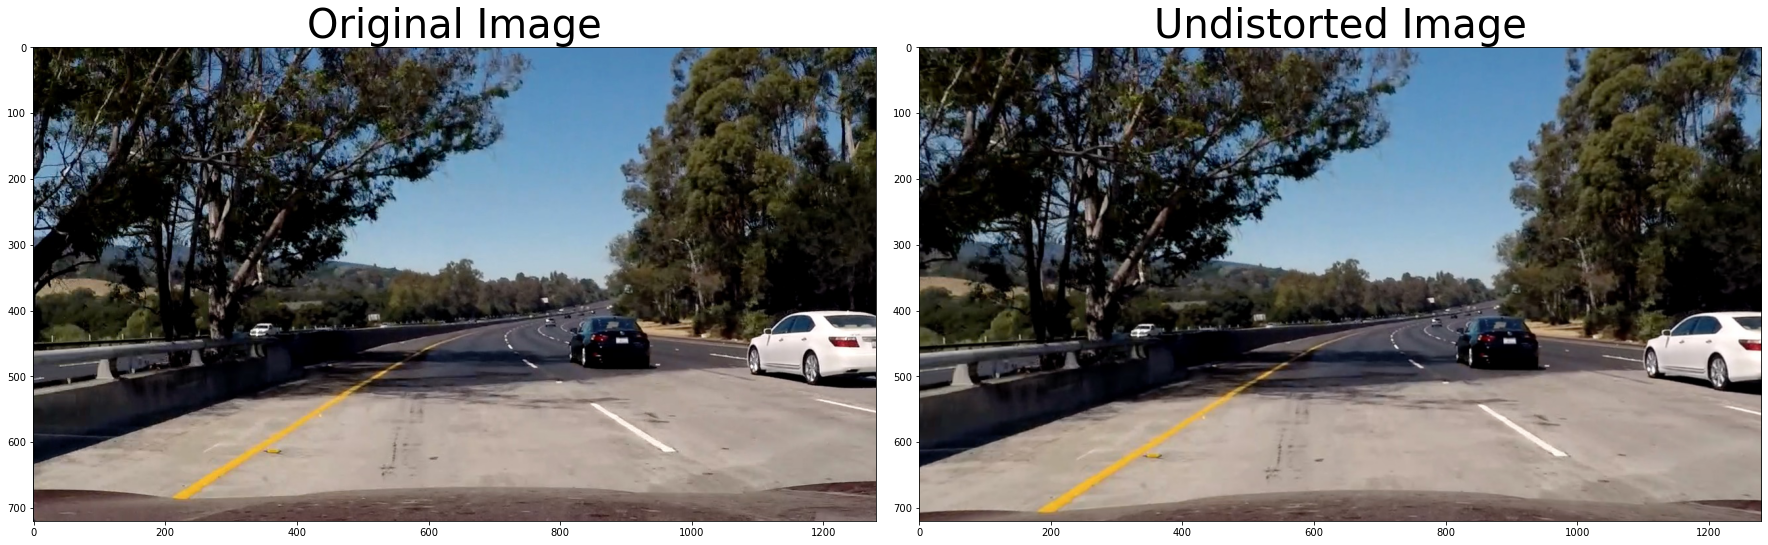

In [10]:
## Step 1: Undistort the image
# Load the pickle file where mtx and dist are saved
pickle_fn = "P2_dist_pickle.p"
dist_pickle = pickle.load( open( "P2_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# Undistort the image based on the mtx and dist
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

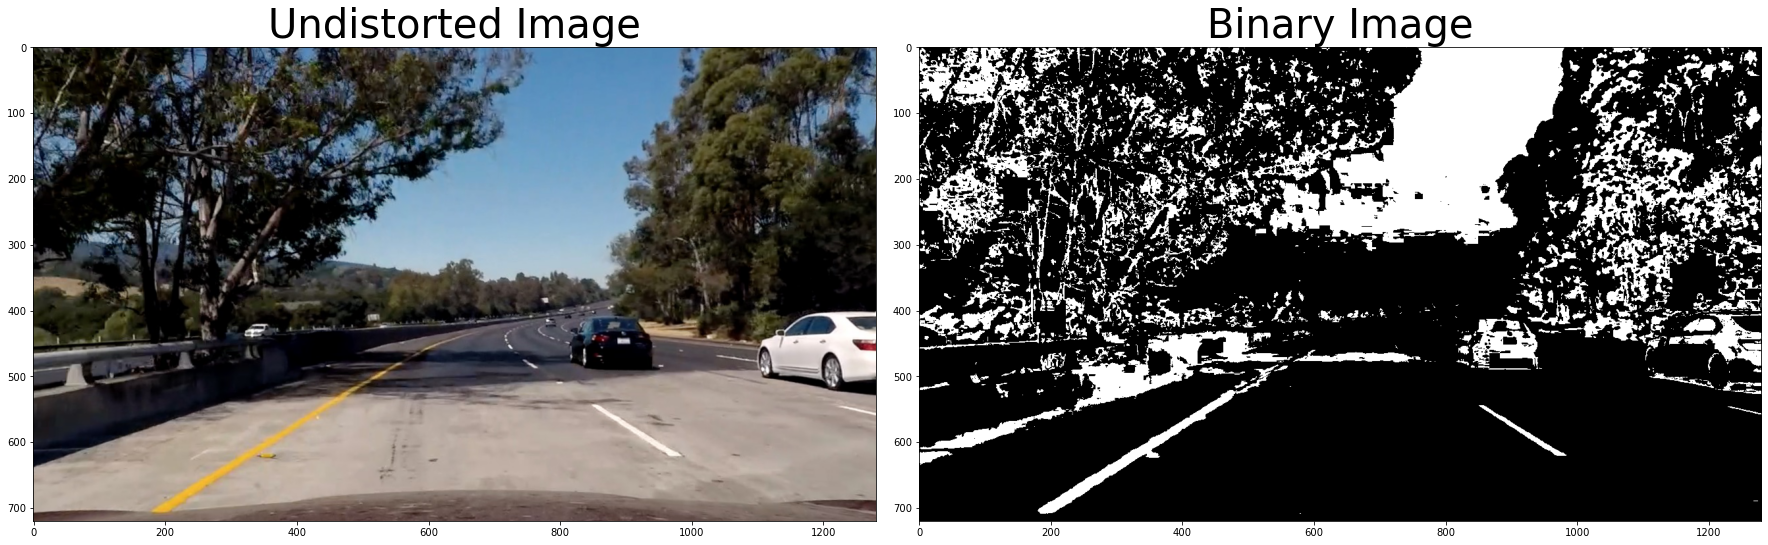

In [11]:
## Step 2: Create the thresholded binary image
binary_img = threshold_binary(undist_img, sobel_kernel=3, s_thresh=(100, 255), gd_thresh=(0, np.pi/2))
# Visulization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Undistorted Image', fontsize=40)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

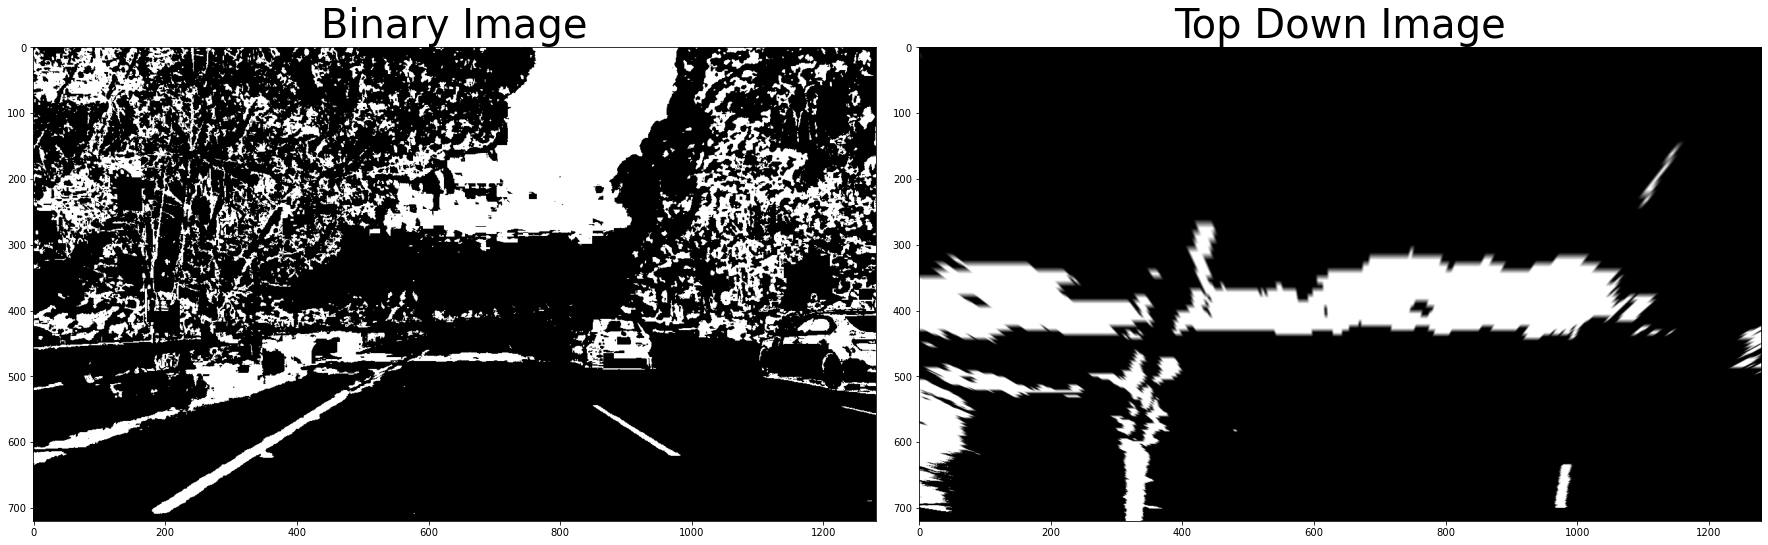

In [12]:
## Step 3: Perform perspective transform
binary_warped, M, Minv = perspective_transform(binary_img, mtx, dist)
# Visulization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_img, cmap='gray')
ax1.set_title('Binary Image', fontsize=40)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Top Down Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


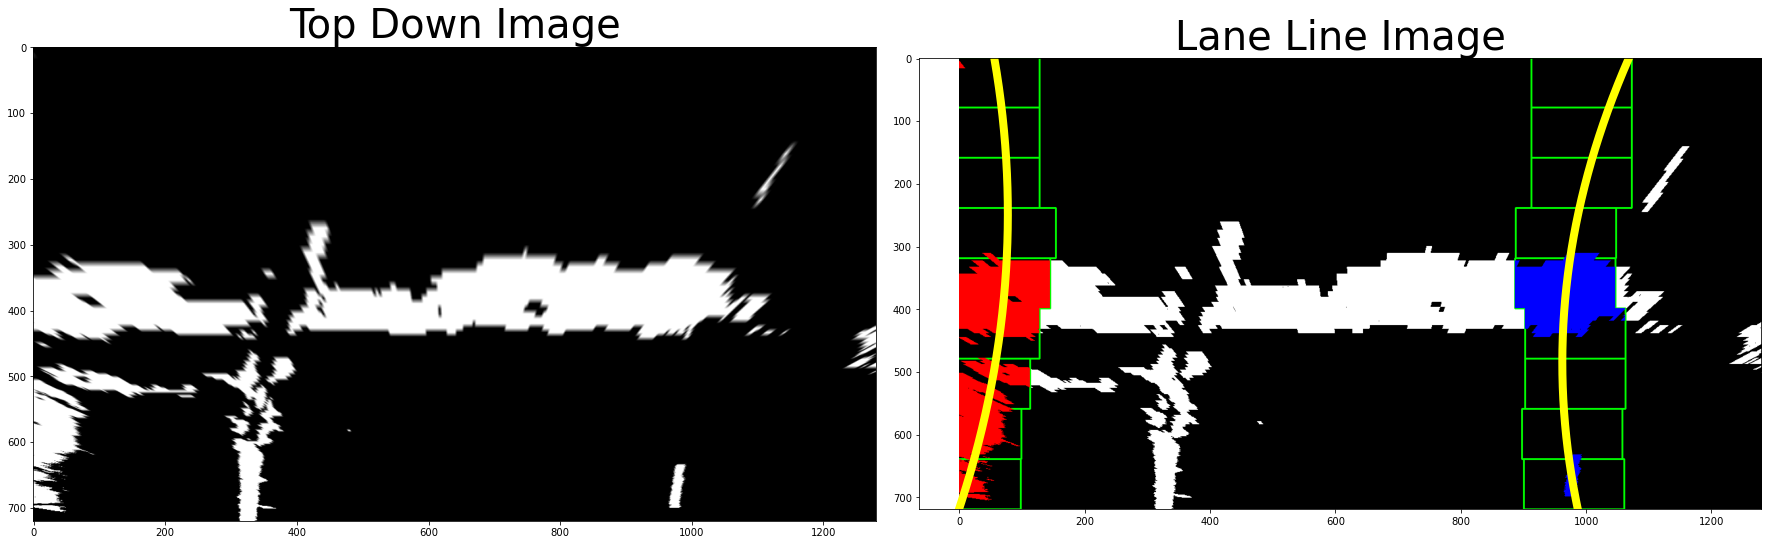

In [13]:
## Step 4: Identify lane-line pixels and fit their positions with a polynomial
# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, \
                                                         nwindows=9, \
                                                         margin=80, \
                                                         minpix=30)
# Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Visulization
# Plots the left and right polynomials on the lane lines
# Generate x and y values for plotting
yvals = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
try:
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*yvals**2 + 1*yvals
    right_fitx = 1*yvals**2 + 1*yvals

# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Top Down Image', fontsize=40)
ax2.imshow(out_img)
plt.plot(left_fitx, yvals, color='yellow', linewidth=8)
plt.plot(right_fitx, yvals, color='yellow', linewidth=8)
ax2.set_title('Lane Line Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
## Step 5: Calculate the radius of curvature of the lane and the position of the vehicle with respect to center
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
left_fitx_cr = left_fit_cr[0]*(yvals*ym_per_pix)**2 + left_fit_cr[1]*yvals*ym_per_pix + left_fit_cr[2]
right_fitx_cr = right_fit_cr[0]*(yvals*ym_per_pix)**2 + right_fit_cr[1]*yvals*ym_per_pix + right_fit_cr[2]

# Calculate radius of curatures
left_curverad, right_curverad = measure_curvature(left_fit_cr, right_fit_cr, yvals*ym_per_pix)
# Calculate the difference between car center to lane center
lane_center_x = (left_fitx_cr[-1]+right_fitx_cr[-1])/2
car_center_x = 1280/2*xm_per_pix
# Negative means the car is on the left of the lane center
center_x_diff = car_center_x - lane_center_x

# Visulization
print("Center difference: {d:.4f} m".format(d=center_x_diff))
print("Curvatures: {0:.4f} m and {1:.4f} m".format(left_curverad, right_curverad))

Center difference: 0.7769 m
Curvatures: 469.3108 m and 364.8918 m


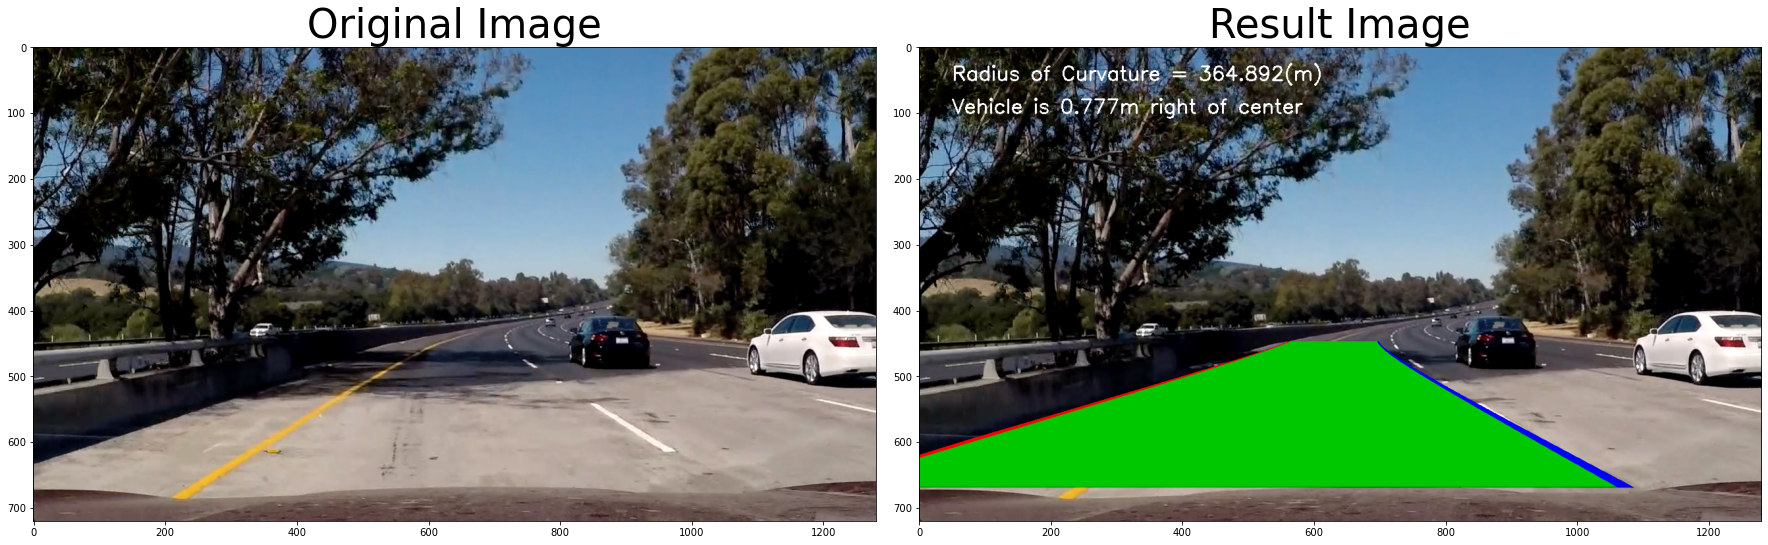

In [15]:
## Step 6: Put the result plotted back down onto the road such that the lane area is identified clearly.
left_fitx = np.array(left_fitx, np.int32)
right_fitx = np.array(right_fitx, np.int32)
window_width = 20
# Lane areas
left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0), \
                              np.concatenate((yvals,yvals[::-1]), axis=0))),np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0), \
                               np.concatenate((yvals,yvals[::-1]), axis=0))),np.int32)
# Middle area
middle_marker = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0), \
                                  np.concatenate((yvals,yvals[::-1]), axis=0))),np.int32)
road = np.zeros_like(img)
road_bkg = np.zeros_like(img)
cv2.fillPoly(road, [left_lane], color=[255,0,0])
cv2.fillPoly(road, [right_lane], color=[0,0,255])
cv2.fillPoly(road, [middle_marker], color=[0,200,0])
cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])
cv2.fillPoly(road_bkg, [middle_marker], color=[255,255,255])
# Put marked lanes and middle area back into original image
img_size = (img.shape[1], img.shape[0])
road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)
base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)

curverad = min(left_curverad,right_curverad)
cv2.putText(result, 'Radius of Curvature = '+str(round(curverad,3))+'(m)', \
            (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
side_pos = 'left'
if center_x_diff>=0:
    side_pos = 'right'
cv2.putText(result, 'Vehicle is '+str(round(abs(center_x_diff),3))+'m '+side_pos+' of center', \
            (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

# Visulization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result)
ax2.set_title('Result Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Pipline for video